# Team: Graduate student descent
### Student IDs: 759073, 767006
### Emails: tollefej@stud.ntnu.no, magnumos@stud.ntnu.no
### Challenge ID: 2
### Challenge name: Santander Customer Transaction Prediction

___

# Contents
### EDA 📊
- Data loading: loading and check for structural errors
- Defining helper functions for fetching feature/label sets
- Checking for imbalance
- Verifying imbalance with scatter plots
- Checking data types
- Checking for unique and duplicate features
- Check for NaN
- Explore possible missing values
- Looking at correlations between features
    - Correlation matrix
    - Correlation top 10/bottom 10 feature pairs

### Data preprocessing and feature engineering 📃
- Check the statistical properties of the data (std, var, z-score)
- Look for "suspect features"
- Filter rows based on z-score
- Adding statistical meta features
- Under- and oversampling

### Exploring models, training, evaluation and feature importance 🤖
- XGBoost
- LightGBM simple version
- AdaBoost
- Neural networks
- LightGBM on individual features
    - Train on individual features
    - Prediction smoothing
    - Parameter tuning and validating on Kaggle
- CatBoost (best results)

### Prediction results ✅
- Kaggle results on the full test set

### Interpretation and conclusion 👩‍🏫

- LIME, se på slides (TODO)

In [45]:
import sklearn
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
import gc
import os
import sys
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import display

# EDA 📊

## Data loading
Let's start by loading the data properly, checking for structural errors etc.

In [3]:
train = pd.read_csv('train_small.csv', header=None)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70057 entries, 0 to 70056
Columns: 202 entries, 0 to 201
dtypes: float64(200), int64(1), object(1)
memory usage: 108.0+ MB


In [4]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
0,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
1,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
2,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
3,train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
4,train_6,0,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,...,8.7830,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097


We see that there are no headers in this file (the subset). Re-read without header, and add a prefix F (feature) to it instead.
We can also note that the first column seems to be a simple label for each data row, train_N for N = 0...n. Make sure that this is correct by checking the unique values in this row, and if this is the case, remove it.


In [5]:
if not train.empty and len(train[0].unique()) == train.shape[0]:
    print('Train_N column is useless')

Train_N column is useless


In [6]:
# create a function with more flexibility
def get_data(header=0, custom_file=None):
    data = custom_file if custom_file else 'train.csv'
    prefix = '' if header == 0 else 'var_'
    df = pd.read_csv(data, header=header, prefix=prefix)
    return df.iloc[:, range(1, df.shape[1])]

train = get_data()

In [7]:
display(train.head())
display(train.info())

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 201 entries, target to var_199
dtypes: float64(200), int64(1)
memory usage: 306.7 MB


None

In [8]:
len(train[train.isna().any(axis=1)]) # test for nan rows

0

As we can see here, the amount of rows with NaN values are 0. We can therefore conclude that there are no NaN values. 

It can however be the case that NaN values have been pre-filled with other default values. 



## Helper functions
Let's create some functions to extract the features and label(s) from datasets, before continuing analysis.

We want to split our `train` set used so far into `X` (features) and `y` (labels)

In [9]:
# some functions to simplify the process of extracting the targets and features later on.
def get_feats(data, only_vals=False):
    feats = data.iloc[:, 1:]
    return feats

def get_labels(data, only_vals=False):
    labels = data.iloc[:, 0]
    return labels

def get_xy(data, only_vals=False):
    X = get_feats(data, only_vals)
    y = get_labels(data, only_vals)
    if only_vals:
        return X.values, y.values
    return X, y


# functions to check for csvs and store them.
def isfile(f):
    return os.path.isfile('data/' + f)

def savefile(df, file):
    df.to_csv('data/' + file, index=False)

In [10]:
X, y = get_xy(train)
display(X)
display(y)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,-0.6209,5.6669,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,-3.6797,6.0019,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,0.1202,6.1629,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,-2.1926,8.7542,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


0         0
1         0
2         0
3         0
4         0
         ..
199995    0
199996    0
199997    0
199998    0
199999    0
Name: target, Length: 200000, dtype: int64

# Looking at the data 📊👀

Univariate feature visualization

In [11]:
X.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,6.618800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,7.629600,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,8.584425,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,11.150600,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [12]:
def get_data_with_target(data, column, target):
    return data.loc[data[column] == target]

def print_balance_of_data(data):
    first_col = data.columns[0]
    for label in data[first_col].unique():
        nrows = get_data_with_target(data, first_col, label).shape[0]
        print('Label: {} has {} rows, or {}%'.format(label, nrows, round(nrows/data.shape[0] * 100, 2)))
        
if not train.empty:
    print_balance_of_data(train)

Label: 0 has 179902 rows, or 89.95%
Label: 1 has 20098 rows, or 10.05%


## Data types

In [13]:
print(X.dtypes.value_counts())
print(y.dtypes)

float64    200
dtype: int64
int64


We can see that only the "target" is of `int64`, the rest (200 features) are floats, thus all our data is numerical

Our data is extremely imbalanced (a ratio of 9:1)! Let's continue looking at the data before looking at potential methods to handle this imbalance.


## Verifying imbalance: Scatter plots
A way to do verify the imbalance is to look at some scatter plots:

In [18]:
def scatter_plot(data, feat1, feat2, target, reg=False):
    sns.lmplot(feat1, feat2, data, hue=target, fit_reg=reg)
    fig = plt.gcf()
    fig.set_size_inches((20,5))
    plt.show();

['var_77', 'var_138', 'var_109'] ['var_182', 'var_33', 'var_88']
var_77 var_182


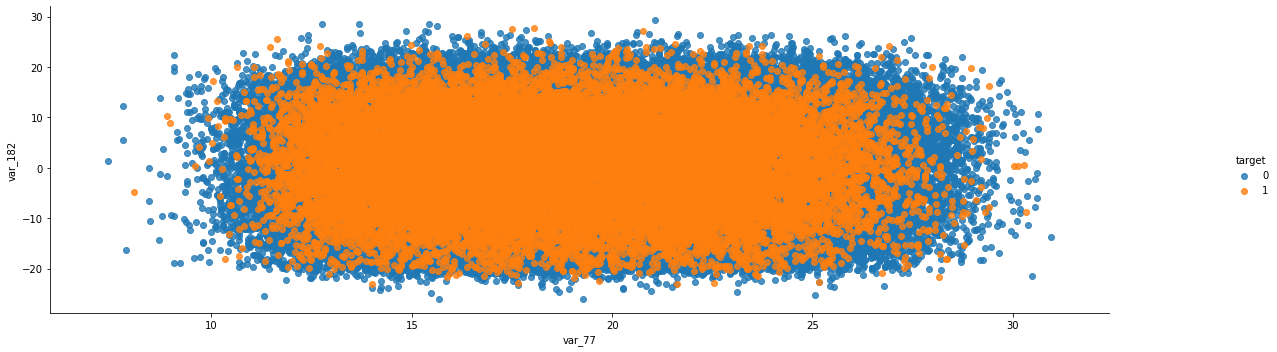

var_77 var_33


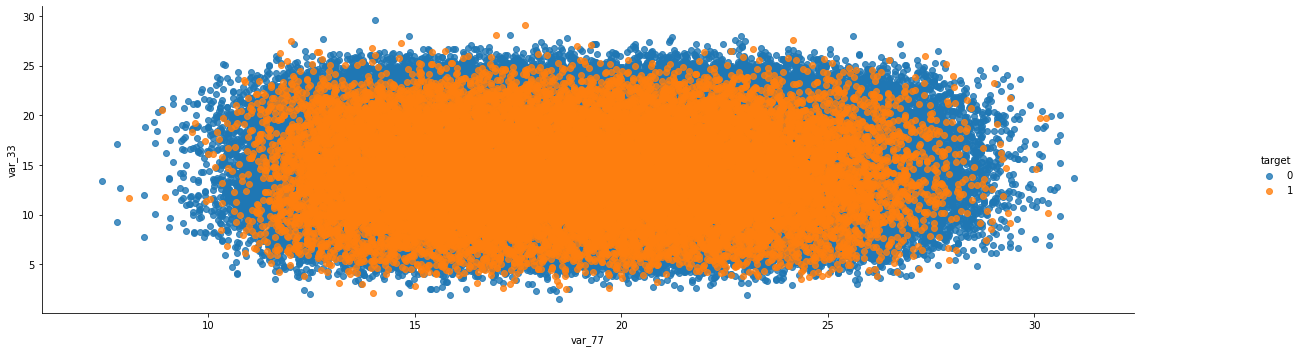

var_77 var_88


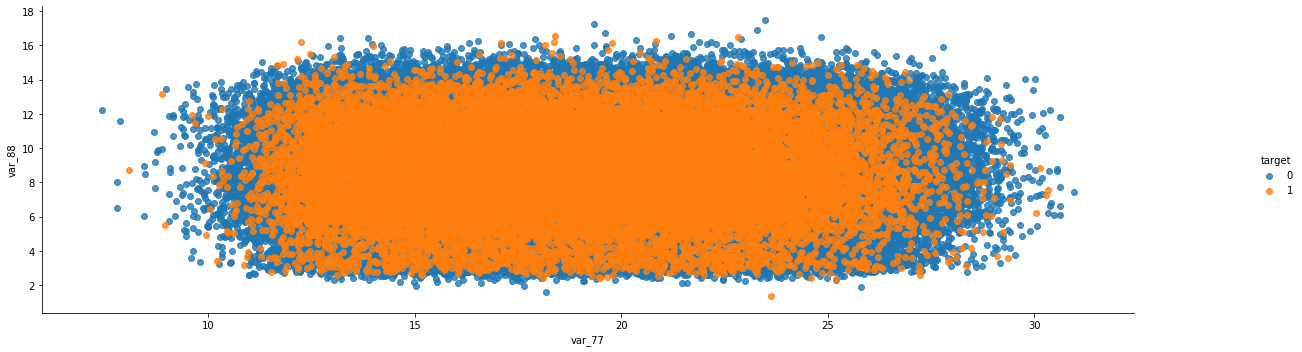

var_138 var_182


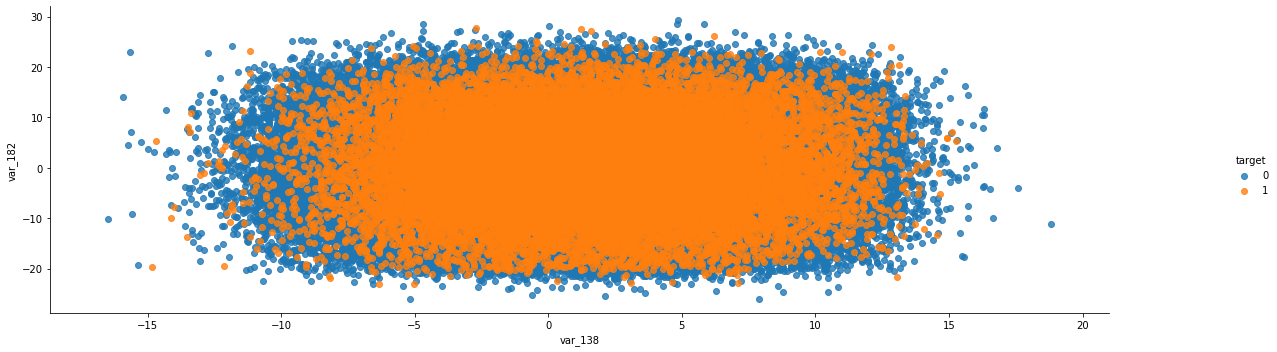

var_138 var_33


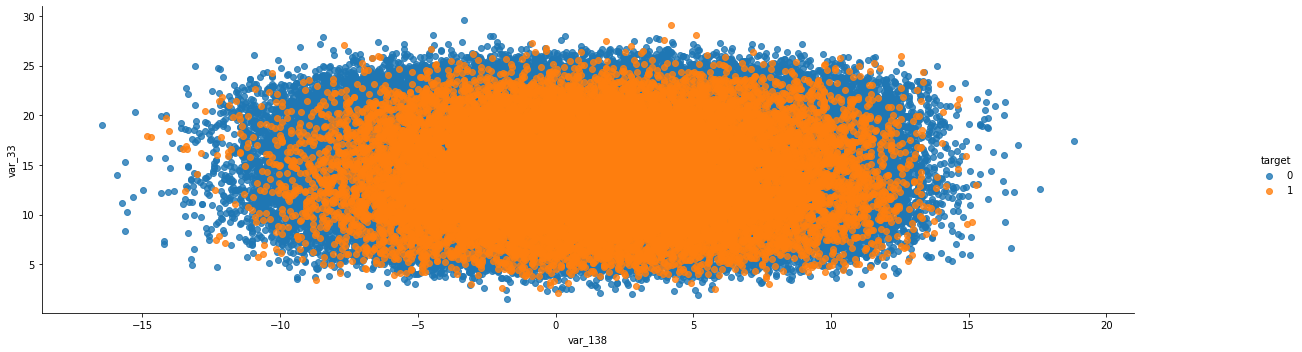

var_138 var_88


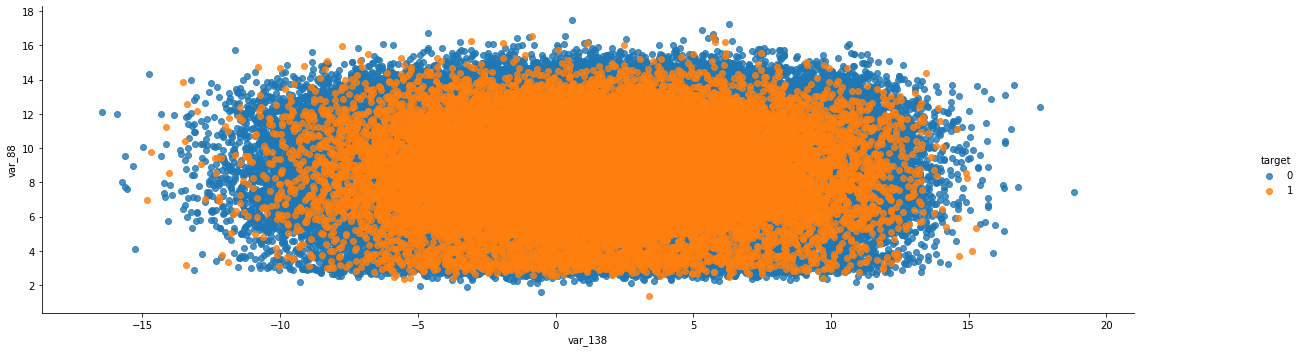

var_109 var_182


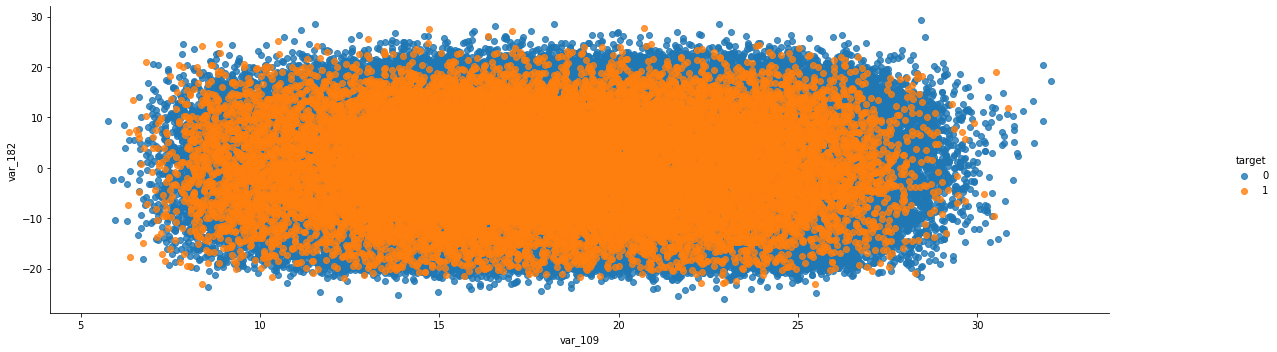

var_109 var_33


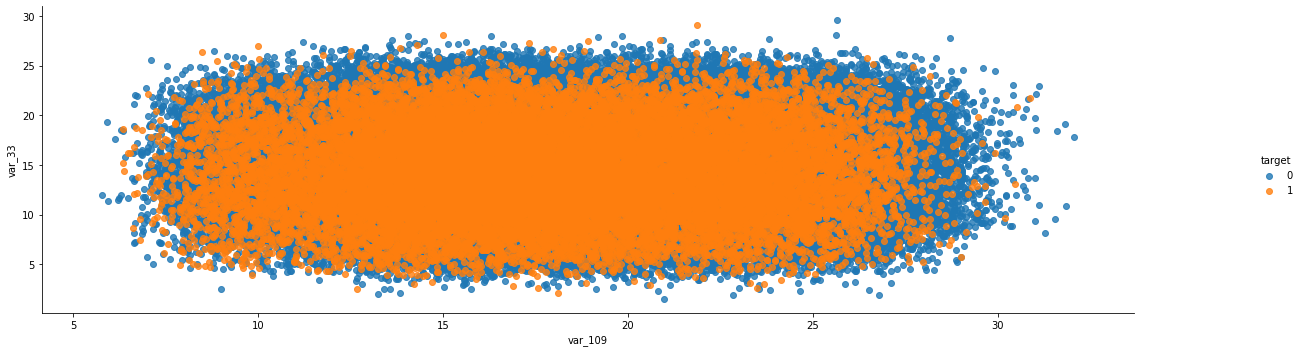

var_109 var_88


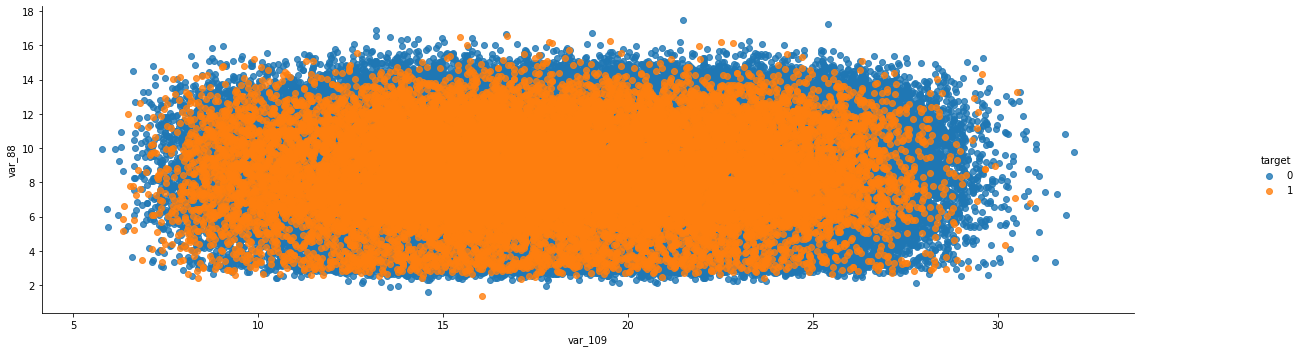

In [19]:
import random

def random_scatters(data):
    random_feats_1 = random.choices(data.columns, k=3)
    random_feats_2 = random.choices(data.columns, k=3)

    print(random_feats_1, random_feats_2)
    for f in random_feats_1:
        for f2 in random_feats_2:
            print(f,f2)
            scatter_plot(data, f, f2, 'target')
            
random_scatters(train)

From the simple prints of the dataset above, we can note that there are seemly no correlations in the data (in the respective features plotted), as the data resulting in 1s and 0s are overlapping, with few outliers. We cannot easily check for outliers by intuition. However, we need to further explore this by analyzing the data itself.

## Finding duplicate rows and columns in the dataset


In [20]:
print('Amount of duplicates: {}'.format(sum([x for x in X.duplicated() if x])))

Amount of duplicates: 0


In [21]:
# number of unique values in each column...
uniq = X.nunique()
print('Min #unique values: {}, and max: {}'.format(min(uniq), max(uniq)))

Min #unique values: 451, and max: 169968


A minimum of a few hundred different values is still quite high. It's not likely that we'll find many repeated values.

Let's look for these by checking the missing values and value count of each column...

In [22]:
constants = X.columns[X.nunique() == 1]
print('Total constant rows: {}'.format(len(constants)))

Total constant rows: 0


## Missing values

In [20]:
def num_missing(data):
    return sum([x for x in data.isnull().sum()])

print('Total missing values: {}'.format(num_missing(train)))

Total missing values: 0


One quick takeaway from this is that we can disregard categorical values completely, leaving onehot-encoding out of the picture, as well as the need for any interpolation algorithms to fill in missing values.


### An initial assumption...
Although there's no missing values, **(1) the dataset could possibly be instantiated with another default value for missing values, such as `-1` or `0`**. We know all values are floats, so these are plausible candidates. We can look for **(2) irregularities in the distribution of the feature values**. However, a quick replacement of `0` and `-1` to `NaN`, then checking the number of missing values again, can be an indicator:

In [21]:
to_replace = X
replaced = to_replace.replace([-1, 0], np.nan)
print(num_missing(replaced))

244


,missing
var_1,2
var_5,6
var_8,1
var_10,2
var_11,4
...,...
var_192,3
var_193,1
var_195,8
var_196,3


Missing vals: [ 2  6  1  2  4  3  1  2  1  6  3  4  2  2  2  3  3  4  3  4  2  1  3  1
  2  1  2  3  1  2  2  1  1 17  1  1  7  1  4  4  1  2  6  3  2  5  5 15
  7  4  2  3  3  3  1  3  2  3  6  9  2  1  3  2  6  1  2  2  1  3  2  3
  1  8  3  4]


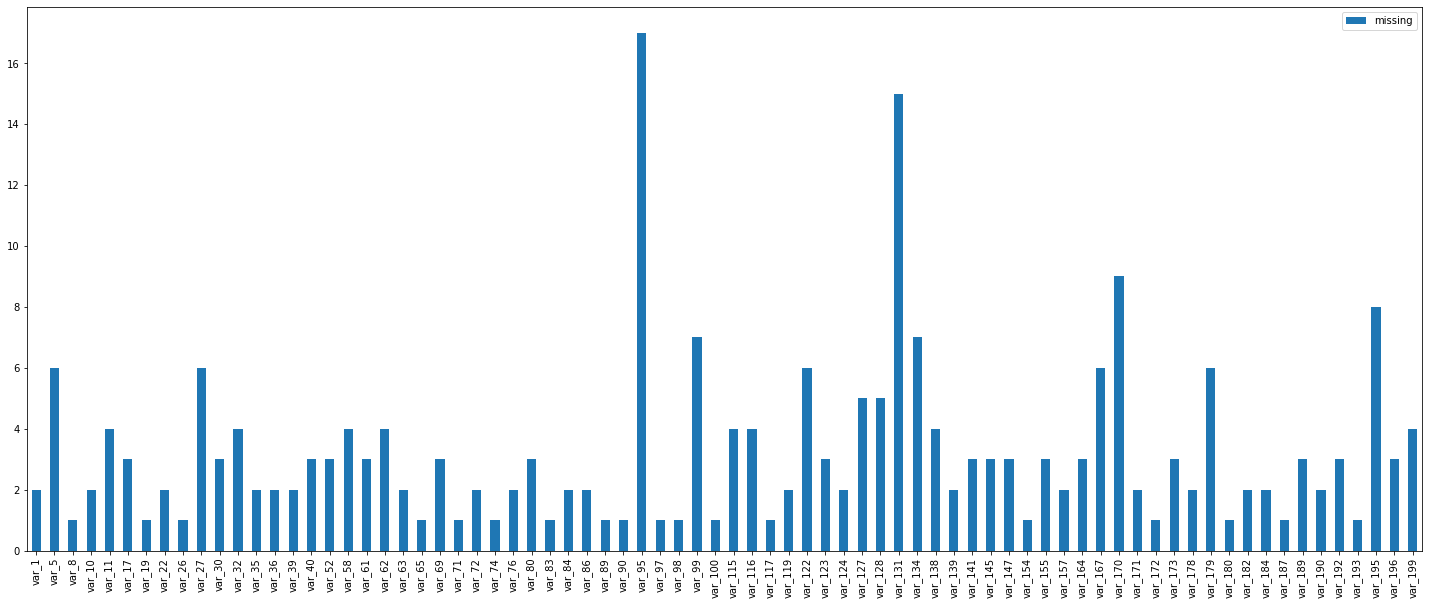

In [22]:
# create a dataframe "mv = missing values" containing replaced values
mv = pd.DataFrame({'missing': replaced.isnull().sum()})
# remove rows without "missing" values
mv = mv[(mv.T != 0).any()]
display(mv)

# create a numpy array and calculate a threshold of 3 * standard deviation
missing_values_list = mv.values.flatten()
print('Missing vals: {}'.format(missing_values_list))
npmv = np.array(missing_values_list)
threshold = np.floor(3*np.std(npmv))

fig, ax = plt.subplots(figsize=(25,10))
ax.set_xticks(np.arange(len(mv)))
mv.plot(ax=ax, kind='bar')

We see that there are a few columns here with somewhat high values

In [23]:
suspect_features = mv.where(mv >= threshold).dropna().T.columns

for feat in suspect_features:
    # describe this suspect feature!
    print(X[feat].describe())

count    200000.000000
mean         -0.084344
std           0.621125
min          -2.432400
25%          -0.527400
50%          -0.098600
75%           0.329100
max           1.804000
Name: var_95, dtype: float64
count    200000.000000
mean          0.544674
std           0.456280
min          -0.954800
25%           0.207800
50%           0.556600
75%           0.901000
max           2.192300
Name: var_131, dtype: float64
count    200000.000000
mean         -0.004962
std           4.424621
min         -14.506000
25%          -3.258500
50%           0.002800
75%           3.096400
max          16.731900
Name: var_170, dtype: float64
count    200000.000000
mean         -0.142088
std           1.429372
min          -5.261000
25%          -1.170700
50%          -0.172700
75%           0.829600
max           4.272900
Name: var_195, dtype: float64


<Figure size 432x288 with 0 Axes>

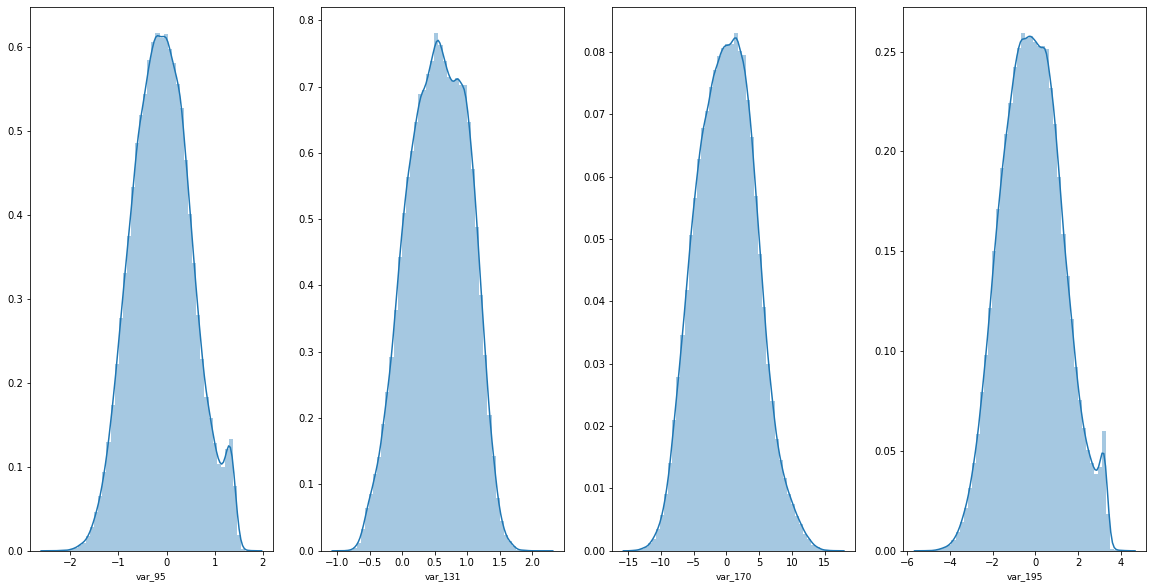

In [24]:
# set up a distrbution plot
def plot_dist(df, features):
    plt.figure()
    nrows, ncols = 1, len(features)
    fig, ax = plt.subplots(nrows, ncols, figsize=(20, 10))

    fignum = 0
    for feature in features:
        fignum += 1
        plt.subplot(1, len(features), fignum)
        sns.distplot(df[feature])
        plt.xlabel(feature, fontsize=9)
    plt.show()
    
plot_dist(X, suspect_features)

<Figure size 432x288 with 0 Axes>

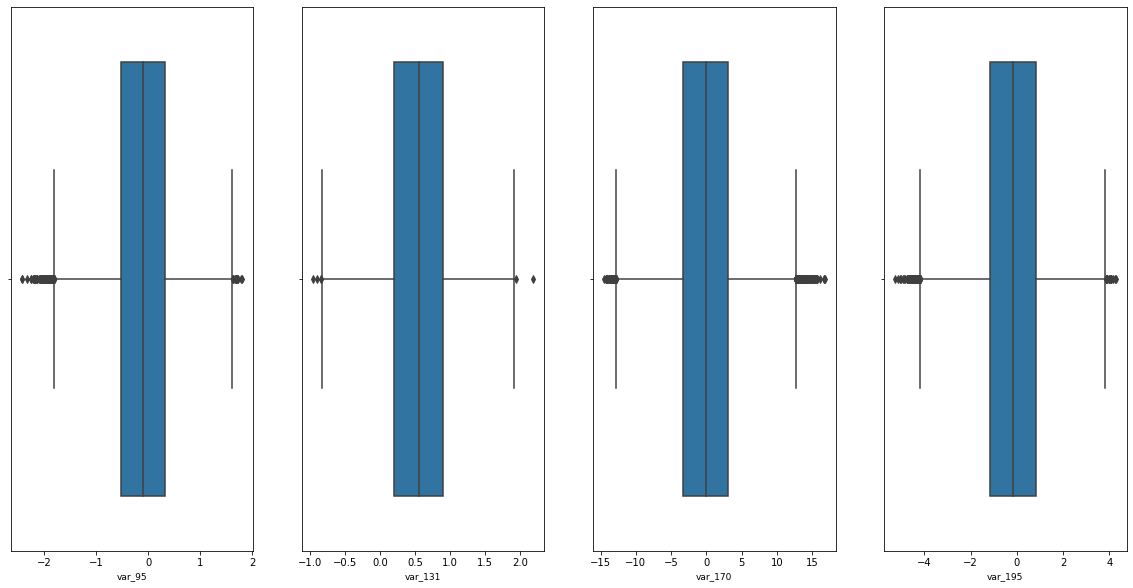

In [25]:
# let's try look at the box plots for statistical nuances
def box_plot(df, features):
    plt.figure()
    nrows, ncols = 1, len(features)
    fig, ax = plt.subplots(nrows, ncols, figsize=(20, 10))

    fignum = 0
    for feature in features:
        fignum += 1
        plt.subplot(1, len(features), fignum)
        sns.boxplot(x=df[feature])
        plt.xlabel(feature, fontsize=9)
    plt.show()
    
box_plot(X, suspect_features)

While we can spot some outliers, we cannot yet conclude that the data is bad. We will contionue to analyze:

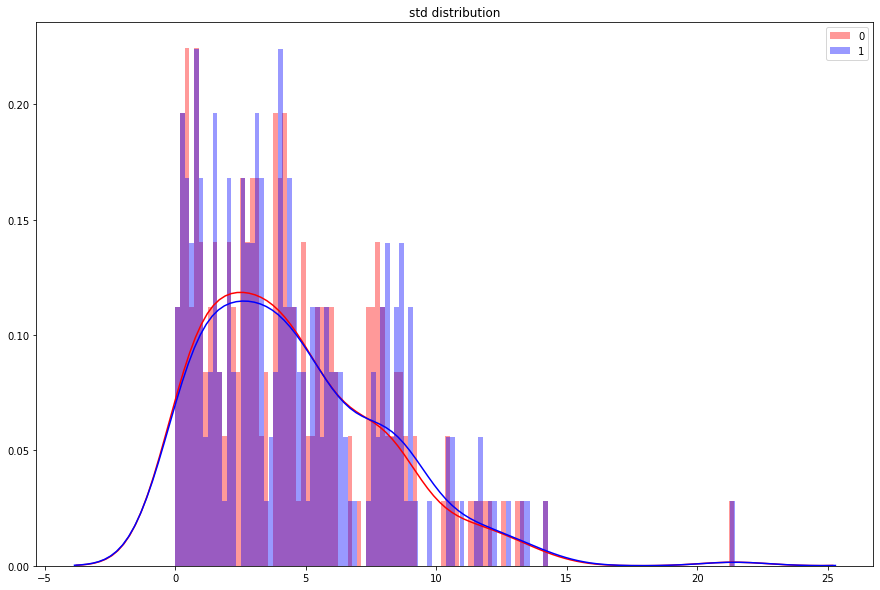

In [26]:
# with some help from the following articles
# https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
# https://www.kaggle.com/roydatascience/eda-pca-simple-lgbm-on-kfold-technique

# plot the std values, to have an idea of what we can expect:
t0 = X.loc[y == 0]
t1 = X.loc[y == 1]
plt.figure(figsize=(15, 10))
plt.title("std distribution")
features = X.columns
sns.distplot(t0[features].std(axis=0),color="red", kde=True, bins=120, label='0')
sns.distplot(t1[features].std(axis=0),color="blue", kde=True, bins=120, label='1')
plt.legend()
plt.show()

It is clear that we are to expect a decent amount of outliers, with several peaks in the std. In the KDE plot (the probability density line), we see that the labeled data for 0 and 1 is similar, so we can assume that the outliers are safe to filter out, while keeping the same ratio of data repsective to 0 and 1.

Let's look at the interquantile range:

In [27]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

X_filtered_IQR = (X < (Q1 - 1.5 * IQR)) |(X > (Q3 + 1.5 * IQR))
X_filtered_IQR_rows = X_filtered_IQR.any().loc[lambda row : row]  # filter where rows are true
filtered_features = X_filtered_IQR_rows.index
filtered_features

Index(['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7',
       'var_8', 'var_10',
       ...
       'var_189', 'var_190', 'var_191', 'var_192', 'var_193', 'var_194',
       'var_195', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=189)

A staggering amount of rows are outside of the interquantile range, 189 out of 200! Anyhow, let's check the variables in the `suspected_features`, as we can see that three of them clearly have outliers.

We obviously expect these to be true.

In [28]:
for feat in suspect_features:
    print('suspected feat ({}) in filtered: {}'.format(feat, feat in filtered_features))

suspected feat (var_95) in filtered: True
suspected feat (var_131) in filtered: True
suspected feat (var_170) in filtered: True
suspected feat (var_195) in filtered: True


In [29]:
parsed_values = []
for col in X.columns:
    valuecounts = X.loc[:, col].value_counts()
    avg = np.mean(valuecounts)
    parsed_counts = valuecounts[valuecounts > avg]
    parsed_values.append((col, len(valuecounts), np.std(valuecounts), np.max(valuecounts)))
    print('{} has {} (out of {}) values above the average value count ({}). STD: {}, Max: {}'.format(
        col, len(parsed_counts), len(valuecounts), avg, np.std(valuecounts), np.max(valuecounts)
    ))

var_0 has 28690 (out of 94672) values above the average value count (2.112557039040054). STD: 1.3070939175828944, Max: 11
var_1 has 54245 (out of 108932) values above the average value count (1.836007784673007). STD: 1.0805445376590672, Max: 10
var_2 has 31023 (out of 86555) values above the average value count (2.310669516492404). STD: 1.4502000152923127, Max: 12
var_3 has 34016 (out of 74597) values above the average value count (2.6810729654007535). STD: 1.6620173061061385, Max: 15
var_4 has 23265 (out of 63515) values above the average value count (3.148862473431473). STD: 1.9781595223496324, Max: 15
var_5 has 44425 (out of 141029) values above the average value count (1.418148040473945). STD: 0.7083485985726024, Max: 7
var_6 has 16103 (out of 38599) values above the average value count (5.181481385528122). STD: 3.4705861290766586, Max: 22
var_7 has 55909 (out of 103063) values above the average value count (1.9405606279654193). STD: 1.1320791654828581, Max: 11
var_8 has 27337 (out

In [30]:
parsed_values_sorted = sorted(parsed_values, key=lambda x:-x[2])
# sorted on std
sorted_std = pd.DataFrame(parsed_values_sorted).head(10)
sorted_std.columns = ['feature', '# uniq values', 'std', 'most common value count']
sorted_std.head(10)

,feature,# uniq values,std,most common value count
0,var_68,451,384.183859,1084
1,var_108,8525,17.524337,313
2,var_91,7962,17.033356,66
3,var_12,9561,14.865718,203
4,var_103,9376,13.818671,61
5,var_148,10608,13.755449,59
6,var_161,11071,11.998784,52
7,var_71,13527,9.951175,54
8,var_25,14853,9.660240,41
9,var_125,16059,8.557978,40


From this, we can clearly see that variable `var_68` stands out, with a std of 384 and 451 different values, with 1084 occurrences of the most common value. Due to this, we can probably remove this feature. A histogram (bucket size 200) plot of the column is shown below.

<img src="https://i.imgur.com/es0DGXz.png" />

As the histogram has such a barcode like shape, neighbouring values have very different valuecounts. This is very odd for a data distribution, and could suggest that the **valuecount is of special importance. We keep this in mind, and also attempt to use valuecount as a meta feature added to our model later on**

## Histogram distributions
We will now plot the feature distributions, looking for more nuances in the data

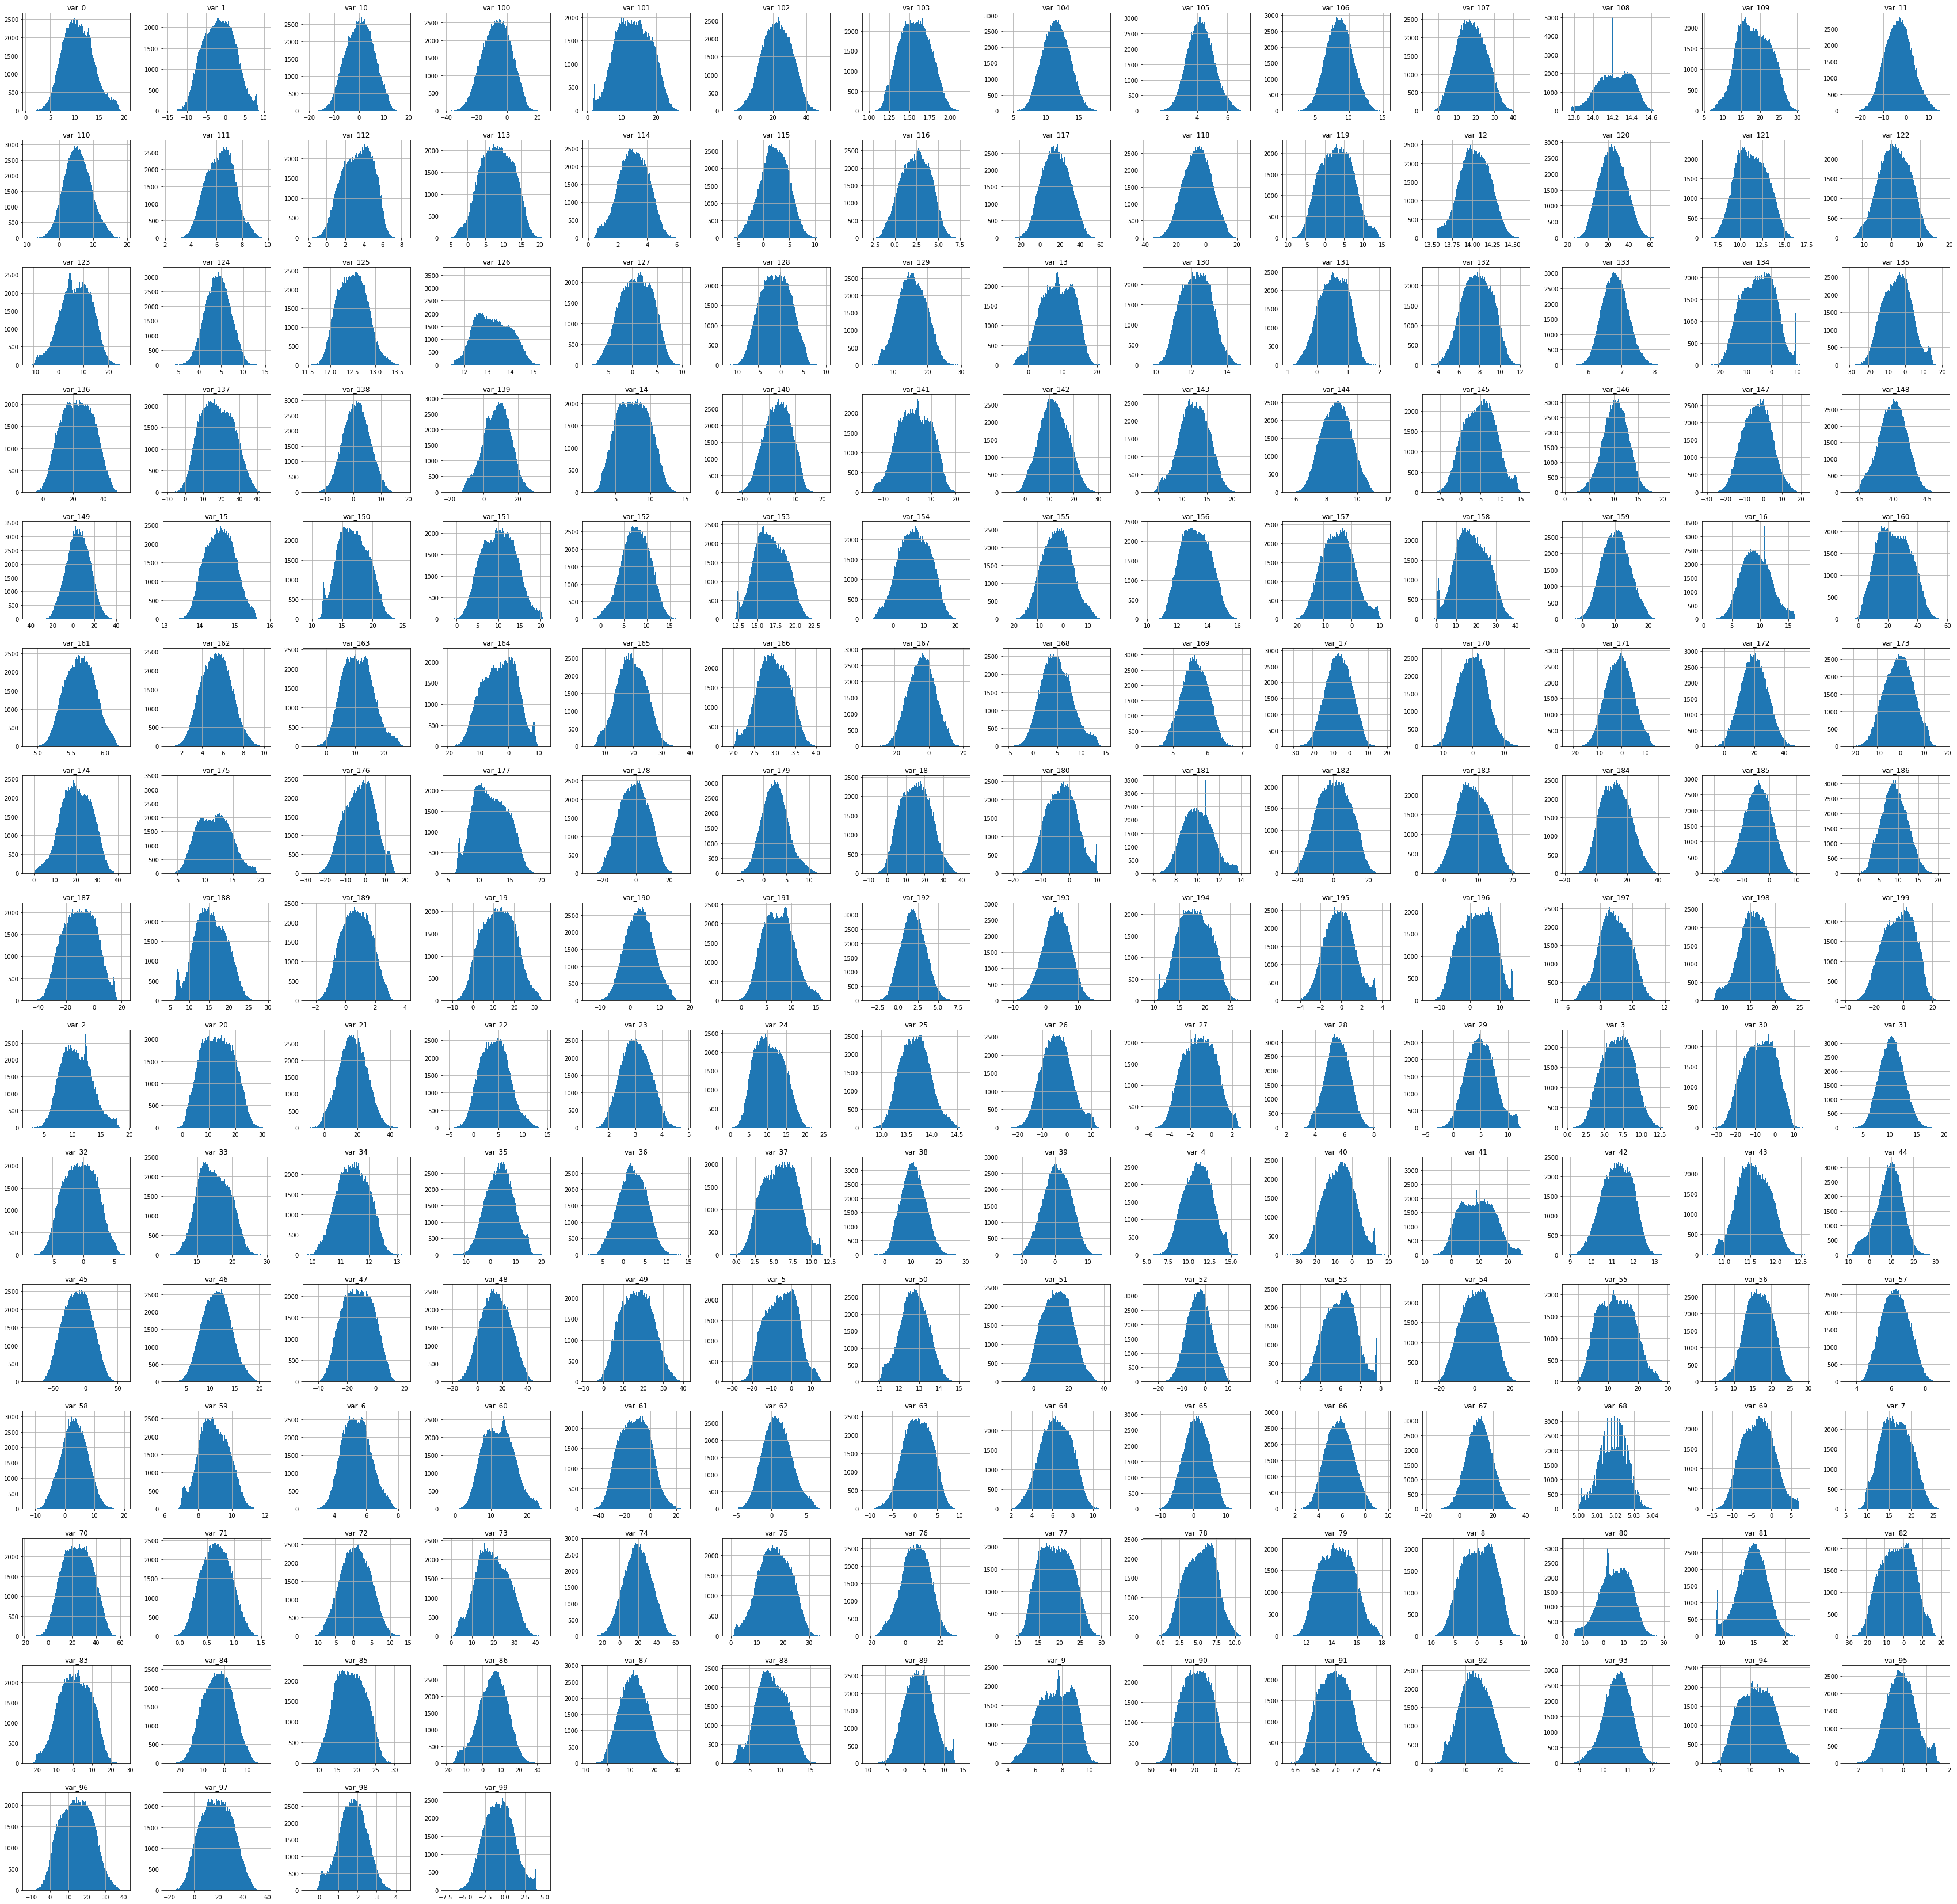

In [32]:
X.hist(figsize=(60,60), bins=200);

After looking at the distributions, let's analyze the Z-scores, as we can clearly see some outliers here outside 3x z-score (99.9% of the data)

A note:
To prune all data within e.g. 99% of the data (a z-score of 2.54), we lost half our data.

# Filtering rows based on Z-score

In [31]:
from scipy import stats

# let's create a function to filter based on a filter function
def filter_data(X, y, filter_func):
    _X = X[filter_func]
    _y = y[filter_func]
    return _X, _y

z = np.abs(stats.zscore(X))
Z_SCORE_LIMIT = 3  # 99.9% of data
z_filter = (z <= Z_SCORE_LIMIT).all(axis=1)
X_filtered, y_filtered = filter_data(X, y, z_filter)

print('Filtered {} values'.format(X.shape[0] - X_filtered.shape[0]))
display(X_filtered)
display(y_filtered)

Filtered 11031 values


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
2,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
5,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,3.5855,5.9790,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,-0.6209,5.6669,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,-3.6797,6.0019,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,0.1202,6.1629,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,-2.1926,8.7542,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


0         0
2         0
3         0
4         0
5         0
         ..
199995    0
199996    0
199997    0
199998    0
199999    0
Name: target, Length: 188969, dtype: int64

As there's little to go on here aside from pure statistical data, let's continue working with the new set without outliers.

In [33]:
X = X_filtered
y = y_filtered

# Bivariate visualization by correlation matrix
After filtering some data, let's see if we can spot some correlations in our data.

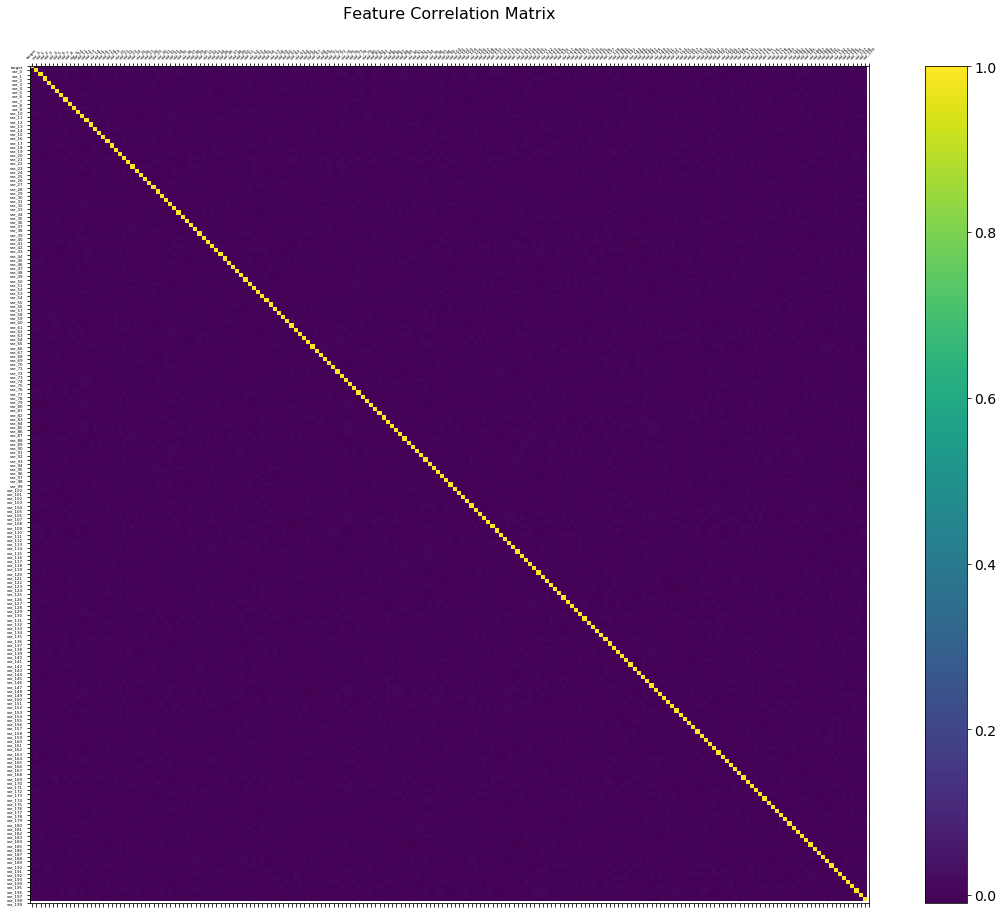

In [36]:
#https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas

def corr_plot(data):
    _size = data.shape[1]
    cols = data.columns
    f = plt.figure(figsize=(20, 15))
    plt.matshow(data[features].corr(), fignum=f.number)
    plt.xticks(range(_size), cols, fontsize=4, rotation=45)
    plt.yticks(range(_size), cols, fontsize=4)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Feature Correlation Matrix', fontsize=16);
    plt.show();

corr_plot(train)

In [37]:
def corr_list(data):
    cols = data.columns.values[1:]
    corrs = data[cols].corr().abs().unstack().sort_values(kind='quicksort', ascending=False).reset_index()
    corrs.columns = ['feat1', 'feat2', 'correlation factor']
    corrs = corrs[corrs.iloc[:, 0] != corrs.iloc[:, 1]]
    print('top 10 correlations')
    display(corrs.head(10))
    print('bottom 10')
    display(corrs.tail(10))
    
corr_list(train)

top 10 correlations


,feat1,feat2,correlation factor
200,var_139,var_26,0.009844
201,var_26,var_139,0.009844
202,var_148,var_53,0.009788
203,var_53,var_148,0.009788
204,var_165,var_81,0.009714
205,var_81,var_165,0.009714
206,var_81,var_174,0.009490
207,var_174,var_81,0.009490
208,var_189,var_183,0.009359
209,var_183,var_189,0.009359


bottom 10


,feat1,feat2,correlation factor
39990,var_100,var_177,3.116544e-07
39991,var_177,var_100,3.116544e-07
39992,var_27,var_144,1.772502e-07
39993,var_144,var_27,1.772502e-07
39994,var_109,var_126,1.313947e-07
39995,var_126,var_109,1.313947e-07
39996,var_6,var_173,5.942735e-08
39997,var_173,var_6,5.942735e-08
39998,var_191,var_75,2.703975e-08
39999,var_75,var_191,2.703975e-08


There is seemingly no correlation between features, with extremely low values. This means that all features are independent of eachother, and enables us to possibly train a model based on each feature separately, giving us many more samples. This can be solved with boosting algorithms, which is something we'll explore now.

Let's check a simple XGBoost model on the entire set, to possibly confirm our findings.

A note: we tried with XGBoost, LightGBM, AdaBoost and Catboost as booster algorithms, and tuned parameters that worked fine with respect to runtime.

In [57]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42069
)

eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
xgbmodel = XGBClassifier(silent=False, 
    learning_rate=0.01,  
    objective='binary:logistic', # we can also try a binary:linear objective
    n_estimators=200,
    max_depth=10, 
)

xgbmodel.fit(X_train, y_train,
    eval_metric=eval_metric,
    eval_set=eval_set,
    early_stopping_rounds = 3,
    verbose=True)

[0]	validation_0-auc:0.704973	validation_0-error:0.087528	validation_1-auc:0.658568	validation_1-error:0.105202
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 3 rounds.
[1]	validation_0-auc:0.712919	validation_0-error:0.087614	validation_1-auc:0.6646	validation_1-error:0.103641
[2]	validation_0-auc:0.716389	validation_0-error:0.087005	validation_1-auc:0.667594	validation_1-error:0.102953
[3]	validation_0-auc:0.720175	validation_0-error:0.087137	validation_1-auc:0.670081	validation_1-error:0.102688
[4]	validation_0-auc:0.728608	validation_0-error:0.087356	validation_1-auc:0.675829	validation_1-error:0.102186
[5]	validation_0-auc:0.730333	validation_0-error:0.087078	validation_1-auc:0.678113	validation_1-error:0.102027
[6]	validation_0-auc:0.732121	validation_0-error:0.087177	validation_1-auc:0.678862	validation_1-error:0.101656
[7]	validation_0-auc:0.739385	validation_0-error:0.087329	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=False, subsample=1, verbosity=1)

Here we can see that the validation auc reaches decent values in its best iteration, meaning that it should be able to distinguish 0s and 1s quite well. Running with deeper trees would result in overfitting, and we deduce that XGBoost is not likely to yield any results for us. (This was tested thoroughly with several hyperparams)

We show the accuracy here to evaluate the model with another feature, but continue to use another model as we're interested in higher AUC scores.

In [58]:
y_pred = xgbmodel.predict(X_test)

In [59]:
err = np.count_nonzero(y_pred - y_test)
print('errors: {}'.format(err))
acc = 100 * (1-err/len(y_test))
print('accuracy = {}'.format(round(acc, 2)))

errors: 3760
accuracy = 90.05


In [60]:
from sklearn.metrics import roc_auc_score

def score(true, predicted):
    s = roc_auc_score(true, predicted)
    print('score: {}'.format(s))

In [61]:
score(y_test, y_pred)

score: 0.5076572533020808


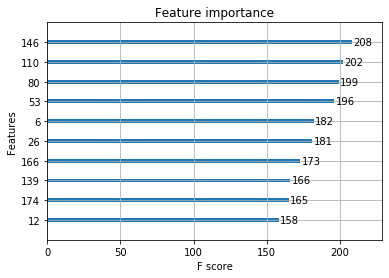

In [62]:
xgb.plot_importance(xgbmodel, max_num_features=10);

This isn't giving us much. An accuracy of 90% is not anything we're interested in continuing with for now, as we expect the model to just predict 0 every time. The feature importance plot tells us that we can probably be fine using the top 50% of features, but given that the AUC resulted in disappointing values, we will try with lightGBM instead.

Start by doing a grid search for a few good parameters we can possibly use later!


We started with the following grid params:
```
params = {"max_depth": [2, 3, 5],
          "learning_rate" : [0.1, 0.01],
          "num_leaves": [3, 6, 12, 32],  # LightGBM docs recommends starting out at 2^max_depth for numleaves, depending on the data
          "n_estimators": [100, 200, 400]
         }
```
And later adjusted to the following (running multiple grid searches, which took tens of hours to train)

depth = 4
LR = 0.1
num_leaves = 5
n_estimators = 4000
         

In [42]:
from sklearn.model_selection import GridSearchCV

lgmodel = lgb.LGBMClassifier(silent=False)
params = {"max_depth": [5],
          "learning_rate" : [0.1],
          "num_leaves": [5],  # LightGBM docs recommends starting out at 2^max_depth for numleaves, depending on the data
          "n_estimators": [4000]
         }

grid_search = GridSearchCV(
    lgmodel,
    n_jobs=-1,
    param_grid=params,
    cv=3,
    scoring="roc_auc",
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=False,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [5],
                  

In [43]:
lgb_best_estimator = grid_search.best_estimator_
lgb_preds = lgb_best_estimator.predict(X_test)
err = np.count_nonzero(y_test - lgb_preds)
acc = 100 * (1-err/len(y_test))
print('accuracy = {}'.format(round(acc, 2)))

accuracy = 92.24


In [44]:
score(y_test, lgb_preds)

score: 0.6727711482009996


While this resulted in somewhat better results, let's try another LGB model, not based on the GridSearch from sklearn

These scores are nearing some pretty good values! A score of 1 is perfect. We will later look at a more advanced LGBM model, yielding better results

After trying XGBoost and LightGBM, we explore Adaboost, as the decision stumps in adaboost help weight the difficult classifications (i.e. the 1s in this dataset):


### We later found that AdaBoost gave us little to go on. It is tremendously slow, and gives sub-par results.

In [ ]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_twoclass.html
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

adamodel = AdaBoostClassifier(
    algorithm='SAMME',
    n_estimators=200)

adamodel.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=1.0,
                   n_estimators=200, random_state=None)

In [ ]:
adapred = adamodel.predict(X_test)
err = np.count_nonzero(y_test - adapred)
acc = 100 * (1-err/len(y_test))
print('accuracy = {}'.format(round(acc, 2)))

accuracy = 90.79


In [ ]:
score(y_test, adapred)

score: 0.5273071202370534


No use for this accuracy. However, we could explore the feature importances discovered by adaboost:

In [ ]:
adafeatures = adamodel.feature_importances_

We discover several zeroed out features.

In [ ]:
labeled_adafeatures = ['var_'+str(i)
                       for i in range(adafeatures.size)
                       if adafeatures[i] > 0.0]
len(labeled_adafeatures)

71

This might be interesting. However, selecting this few features from a set without correlation seems extremely risky. Let's try some other tactic using LightGBM later, where we predict each target for the test data, one feature at a time. This is done simply due to seemingly no correlation, as previously mentioned.


Moving on to looking at under- and oversampling. We attempted all versions showed in the lectures, but SMOTE and Tomek never finished running, and ended up crashing our notebook. We have the plots from both samples below. Due to not being able to run it on the big dataset, we tried with the subset to check for results. Due to the nature of the 90:10 ratio for 0s and 1s in the training and test data, both methods resulted in worse predictions overall.

In [ ]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show();

Using TensorFlow backend.


Removed indexes: [137454  69015 161209 ... 188950 188955 188959]


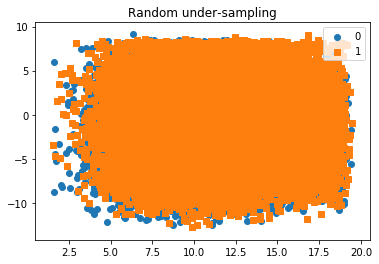

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(return_indices=True)
X_rus, y_rus, id_rus = rus.fit_sample(X, y)

print('Removed indexes:', id_rus)

plot_2d_space(X_rus, y_rus, 'Random under-sampling')

In [ ]:
X_undersampled = pd.DataFrame(X_rus)
y_undersampled = pd.Series(y_rus)
X_undersampled

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,9.1723,-1.2279,14.5256,7.5795,12.3254,-9.9897,4.0653,21.2859,-3.1268,8.9368,...,3.6542,4.3421,-1.0955,7.4265,19.2167,1.2549,-3.4535,10.6033,9.9972,-5.1460
1,8.8383,1.7608,9.1284,8.8732,11.0110,-4.3966,5.1666,17.1084,5.4431,5.9091,...,2.9170,8.4624,3.4910,2.9298,13.3600,-0.5430,5.2702,7.8237,20.9803,13.8665
2,5.9672,-6.9461,13.0066,4.6764,11.3557,-20.2317,4.6531,12.4940,-3.7885,9.1887,...,-3.9063,4.6105,2.4581,2.2493,12.3557,-0.8617,0.4911,8.2877,10.2423,6.6427
3,10.2444,-0.7975,11.4651,2.9426,12.5695,-8.5703,5.3202,16.2395,1.4549,7.9929,...,8.4915,5.9448,2.7541,3.0569,20.5424,-1.2749,5.9682,7.9678,14.9360,-15.6943
4,14.8243,0.3543,10.3935,5.0492,12.0675,7.5599,4.9976,15.9805,0.1498,8.5103,...,6.6236,2.8339,1.9774,3.9333,15.3390,0.2401,-4.2756,6.9665,13.6604,-21.8165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37647,9.8201,-8.7172,12.0309,7.4863,13.9341,-6.3950,7.3970,9.0068,-3.2500,7.6219,...,10.0575,5.7806,3.1498,3.8960,22.7075,1.6411,-4.7972,8.4152,15.7327,-10.9165
37648,7.9663,-2.8485,9.0919,7.3298,9.6690,-16.7872,4.5094,12.4351,-0.0113,8.5394,...,10.7930,4.3876,3.7257,7.7038,14.7384,0.1561,1.5794,8.4627,14.3604,-1.6688
37649,12.8140,0.6386,14.1657,7.1044,8.9365,-0.3274,6.5949,14.6078,-1.0373,8.8974,...,4.8208,4.9010,2.2513,0.7308,14.7155,1.1464,5.5158,8.6519,16.0341,7.3809
37650,12.0298,-8.7800,7.7071,7.4015,9.2305,-16.2174,5.9064,17.9268,3.6489,7.3970,...,16.7461,3.1249,-0.3943,8.4059,14.3367,3.0991,4.3853,8.8019,15.0031,-0.3659


The following was the output training a simple fully-connected NN on the undersampled set:
```
Train on 21084 samples, validate on 9037 samples
...
Epoch 8/100
21084/21084 - 3s - loss: 0.4782 - acc: 0.7707 - binary_crossentropy: 0.4782 - val_loss: 0.5013 - val_acc: 0.7571 - val_binary_crossentropy: 0.5013
Epoch 9/100
21084/21084 - 3s - loss: 0.4794 - acc: 0.7726 - binary_crossentropy: 0.4794 - val_loss: 0.5087 - val_acc: 0.7557 - val_binary_crossentropy: 0.5087
Epoch 10/100
21084/21084 - 3s - loss: 0.4771 - acc: 0.7737 - binary_crossentropy: 0.4771 - val_loss: 0.4947 - val_acc: 0.7647 - val_binary_crossentropy: 0.4947
...
```

In other words, completely useless for even its own validation set. Too few data points.

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=1234, sampling_strategy=0.2)  # also tried with 0.1 -> 0.5 in small increments. No results
X_ros, y_ros = ros.fit_sample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')

In [ ]:
X_oversampled = pd.DataFrame(X_ros)
y_oversampled = pd.Series(y_ros)
X_oversampled

Here we can try to use the new sampled sets as the new feature set, X, if desired:

In [ ]:
USE_SAMPLE = False
USE_OVERSAMPLE = True

orig_X, orig_y = None, None

if USE_SAMPLE:
    orig_X, orig_y = X, y
    if USE_OVERSAMPLE:
        X, y = X_oversampled, y_oversampled
    else:
        X, y = X_undersampled, y_undersampled

## After testing oversampled data...
We found that training with oversampling, especially a neural net, resulted in better results on its own validation set. This is no surprise as it has more data points to look for patterns. With this many new data points correlating to "1" in the target, it gave terrible results on the actual test set.

In [38]:
# standardize!
from sklearn.preprocessing import StandardScaler

def scale(data, cols=None):
    scaler = StandardScaler()
    if cols:
        data = data[cols]

    scaler.fit(data)
    scaled = pd.DataFrame(scaler.transform(data))
    if cols:
        scaled = pd.DataFrame(scaler.transform(data), columns=cols)
    return scaled


## After testing: scaling results in way better models with neural nets! X gets scaled before training. See below.

In [39]:
'''
# commented to avoid saving on other computers :-)

X = None
f = 'scaled_X.csv'

if isfile(f):
    X = pd.read_csv('data/' + f)
else:
    X = scale(X)
    savefile(X, f)
'''
X = scale(X)

In [40]:
'''
yf = 'y.csv'
if isfile(yf):
    y = pd.Series(pd.read_csv('data/' + yf, header=None, index_col=0).values.flatten())
elif y.any():
    y.to_csv('data/'+yf, header=False)
'''
y

0         0
2         0
3         0
4         0
5         0
         ..
199995    0
199996    0
199997    0
199998    0
199999    0
Name: target, Length: 188969, dtype: int64

After having our final X and y (train) data ready. Let's create the new data including value count as a feature, as mentioned earlier.

In [41]:
def value_count_as_feature(df):
    for col in df.columns:
        cv = df[col].value_counts()
        nm = '{}_VC'.format(col)
        df[nm] = df[col].map(cv)
        _type = 'uint8' if cv.max() <= 255 else 'uint16'
        df[nm] = df[nm].astype(_type)
        
VC_X = X.copy()
value_count_as_feature(VC_X)
VC_X

,0,1,2,3,4,5,6,7,8,9,...,190_VC,191_VC,192_VC,193_VC,194_VC,195_VC,196_VC,197_VC,198_VC,199_VC
0,-0.578139,-1.274136,0.452486,-0.833252,0.235720,-0.536940,-0.334952,0.608628,-1.562563,-1.473630,...,3,6,7,3,4,4,3,12,5,2
1,-0.682237,-0.275919,0.517794,0.537366,-0.306366,-0.511544,1.771879,-0.565206,-1.562353,-1.307215,...,3,4,3,1,2,2,3,6,2,2
2,0.124705,-0.129198,-0.667275,0.196106,0.929468,0.410142,0.501427,-0.474632,-1.844959,0.549263,...,1,2,4,3,3,7,4,4,2,2
3,-0.278091,0.035928,0.818617,-0.077156,0.739720,0.955033,0.614277,0.791473,1.794555,0.090428,...,3,4,1,1,1,5,3,5,2,2
4,0.261626,-0.170306,0.717623,0.896493,-0.072051,1.096486,-1.012396,-0.386692,0.990226,-1.285755,...,1,3,1,5,5,3,1,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188964,0.265478,0.279961,-0.928662,-1.606141,-0.455807,2.119859,0.302872,-0.408318,-0.272257,-1.538495,...,4,1,3,3,2,5,1,10,4,2
188965,-1.898494,-0.202472,2.269733,-0.078624,-1.709357,-0.699643,0.544627,1.477027,-1.190307,-1.267211,...,1,2,6,1,2,4,2,3,5,1
188966,0.178301,-0.845633,-0.076123,-0.562732,-1.072705,-0.044177,-0.985483,1.466228,-0.049828,-1.136832,...,3,2,5,2,2,5,1,11,3,1
188967,-0.318289,-1.724625,1.097354,-0.490573,0.887926,0.711538,0.738331,0.137057,-0.743977,0.961616,...,3,4,2,2,3,5,1,6,3,1


We now have 200 new features, each corresponding to a valuecount.

Gradient methods like boosters will not understand the connection between "0" and "VC_0" and so on, which might be an issue. However, we will attempt to do some training on this with a neural network

In [46]:
#X_train, X_test, y_train, y_test
SPLIT_RATIO = 0.1
def split(X, y):
    return train_test_split(
        X, y,
        test_size=SPLIT_RATIO,
        random_state=42)

In [79]:
X_train, X_test, y_train, y_test = split(X, y)

X_VC_train, X_VC_test, y_vc_train, y_vc_test = split(VC_X, y)

In [60]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.metrics import AUC

'''
Some variables for the model saving name
'''
INPUT_DIM = 128
INPUT_DROPOUT = 0.4

HIDDEN_DIM = 256
HIDDEN_DROPOUT = 0.3

OUT_DIM = 128

DEEP_ACTIVATION = 'sigmoid'
OUT_ACTIVATION = 'sigmoid'

input_shape = [X_train.shape[1]]

def build_model():
    model = tf.keras.Sequential([
        Dense(INPUT_DIM, activation=DEEP_ACTIVATION, input_shape=input_shape),
        Dropout(INPUT_DROPOUT),
        
        Dense(HIDDEN_DIM, activation=DEEP_ACTIVATION),
        Dropout(HIDDEN_DROPOUT),
        
        Dense(OUT_DIM, activation=DEEP_ACTIVATION),
        Dense(1, activation=OUT_ACTIVATION)
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['binary_crossentropy', AUC(curve='ROC', name='auc')],
    )
    return model

model = build_model()

In [61]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               25728     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 91,777
Trainable params: 91,777
Non-trainable params: 0
____________________________________________________

In [67]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5)

'''
save the best models based on the following parameters
FEATURES_PERCENTAGE

SPLIT_RATIO
INPUT_DIM
INPUT_DROPOUT

HIDDEN_DIM
HIDDEN_DROPOUT

OUT_DIM

DEEP_ACTIVATION
OUT_ACTIVATION
'''

# storing the model with reproducible names
m_params = [
    'MODEL',
    'SPLIT={}'.format(SPLIT_RATIO),
    'IN_DIM={}&DROP={}'.format(INPUT_DIM, INPUT_DROPOUT),
    'HIDDEN_DIM={}&DROP={}'.format(HIDDEN_DIM, INPUT_DROPOUT),
    'OUT_DIM1={}&ACT={}'.format(OUT_DIM, OUT_ACTIVATION),
    'ACT={}'.format(DEEP_ACTIVATION)
]
m_param_str = '&'.join(m_params) + '.h5'
print(m_param_str)
    
savebest = tf.keras.callbacks.ModelCheckpoint(
    filepath=m_param_str,
    monitor='val_auc',
    save_best_only=True)

def savebest_with_name(name):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=name+'.h5',
        monitor='val_auc',
        save_best_only=True)


callbacks = [earlystop, savebest]

MODEL&SPLIT=0.1&IN_DIM=128&DROP=0.4&HIDDEN_DIM=256&DROP=0.4&OUT_DIM1=128&ACT=sigmoid&ACT=sigmoid.h5


In [63]:
from sklearn.model_selection import StratifiedKFold

# keep the true test set (10% of the data, seen above)
KFOLD_X = X_train.values
KFOLD_y = y_train.values

skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

histories = []

split_num = 1
for i, j in skf.split(KFOLD_X, KFOLD_y):
    fold_X_train, fold_X_test= KFOLD_X[i], KFOLD_X[j]
    fold_y_train, fold_y_test = KFOLD_y[i], KFOLD_y[j]

    model = build_model()
    
    savemodelname = savebest_with_name(str(split_num))
    split_num += 1
    
    fold_history = model.fit(
        fold_X_train,
        fold_y_train,
        validation_data=(X_test, y_test),  # the 10% test data
        epochs=20,
        verbose=0,
        callbacks=[earlystop, savemodelname]
    )
    histories.append(fold_history)

    print('Eval: ({}): {}'.format(model.metrics_names, model.evaluate(fold_X_test, fold_y_test)))

17008/17008 [==============================] - 1s 40us/sample - loss: 0.2445 - binary_crossentropy: 0.2445 - auc: 0.8503
Eval: (['loss', 'binary_crossentropy', 'auc']): [0.2444646668498626, 0.2444647, 0.85034686]
17008/17008 [==============================] - 1s 41us/sample - loss: 0.2344 - binary_crossentropy: 0.2344 - auc: 0.8576
Eval: (['loss', 'binary_crossentropy', 'auc']): [0.23435731568598905, 0.23435725, 0.8576341]
17008/17008 [==============================] - 1s 43us/sample - loss: 0.2330 - binary_crossentropy: 0.2330 - auc: 0.8562
Eval: (['loss', 'binary_crossentropy', 'auc']): [0.23303705983053147, 0.2330371, 0.8561508]
17008/17008 [==============================] - 1s 41us/sample - loss: 0.2344 - binary_crossentropy: 0.2344 - auc: 0.8566
Eval: (['loss', 'binary_crossentropy', 'auc']): [0.2344218125656205, 0.23442174, 0.8565649]
17007/17007 [==============================] - 1s 42us/sample - loss: 0.2512 - binary_crossentropy: 0.2512 - auc: 0.8478
Eval: (['loss', 'binary_cr

In [64]:
for history in histories:
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    display(hist.tail())

,loss,binary_crossentropy,auc,val_loss,val_binary_crossentropy,val_auc,epoch
15,0.214825,0.214824,0.876809,0.238537,0.238537,0.853762,15
16,0.213515,0.213516,0.877941,0.239453,0.239453,0.854516,16
17,0.212576,0.212576,0.879612,0.240709,0.240709,0.852728,17
18,0.211472,0.211472,0.879638,0.240755,0.240755,0.853595,18
19,0.210996,0.210996,0.880796,0.242705,0.242705,0.852544,19


,loss,binary_crossentropy,auc,val_loss,val_binary_crossentropy,val_auc,epoch
1,0.237054,0.237054,0.851057,0.232824,0.232824,0.857397,1
2,0.234022,0.234023,0.854703,0.232845,0.232845,0.856433,2
3,0.232716,0.232715,0.856144,0.232516,0.232516,0.856360,3
4,0.230863,0.230862,0.858608,0.231890,0.231890,0.857140,4
5,0.229013,0.229013,0.860542,0.233494,0.233494,0.855883,5


,loss,binary_crossentropy,auc,val_loss,val_binary_crossentropy,val_auc,epoch
1,0.237339,0.237339,0.850055,0.234825,0.234825,0.856303,1
2,0.235094,0.235095,0.853183,0.233249,0.233249,0.855632,2
3,0.232816,0.232816,0.856758,0.232576,0.232576,0.857619,3
4,0.231139,0.231139,0.858332,0.234159,0.234159,0.856637,4
5,0.229348,0.229348,0.860770,0.233017,0.233017,0.856540,5


,loss,binary_crossentropy,auc,val_loss,val_binary_crossentropy,val_auc,epoch
2,0.234631,0.234632,0.853894,0.232874,0.232874,0.856576,2
3,0.233221,0.233221,0.855534,0.232709,0.232709,0.855811,3
4,0.231098,0.231098,0.858348,0.231973,0.231972,0.856920,4
5,0.229323,0.229323,0.860610,0.235464,0.235464,0.854909,5
6,0.227837,0.227838,0.862166,0.234560,0.234560,0.855954,6


,loss,binary_crossentropy,auc,val_loss,val_binary_crossentropy,val_auc,epoch
15,0.213853,0.213853,0.876402,0.238442,0.238442,0.852939,15
16,0.212425,0.212425,0.877947,0.238072,0.238072,0.852819,16
17,0.211406,0.211406,0.878975,0.238607,0.238607,0.852046,17
18,0.210772,0.210772,0.879499,0.239485,0.239485,0.851889,18
19,0.208923,0.208923,0.881176,0.242226,0.242226,0.850899,19


,loss,binary_crossentropy,auc,val_loss,val_binary_crossentropy,val_auc,epoch
1,0.236512,0.236511,0.851537,0.232491,0.232491,0.856066,1
2,0.234312,0.234311,0.854260,0.233686,0.233686,0.856409,2
3,0.232068,0.232069,0.856989,0.233113,0.233113,0.855147,3
4,0.230597,0.230597,0.858850,0.234748,0.234748,0.854988,4
5,0.228960,0.228960,0.860417,0.233109,0.233109,0.856229,5


,loss,binary_crossentropy,auc,val_loss,val_binary_crossentropy,val_auc,epoch
1,0.237446,0.237446,0.850381,0.234207,0.234207,0.855915,1
2,0.235307,0.235307,0.852577,0.233988,0.233988,0.855773,2
3,0.232842,0.232842,0.856106,0.234403,0.234403,0.856770,3
4,0.231411,0.231411,0.857920,0.233444,0.233444,0.856684,4
5,0.229659,0.229659,0.859744,0.233241,0.233241,0.856123,5


,loss,binary_crossentropy,auc,val_loss,val_binary_crossentropy,val_auc,epoch
15,0.214259,0.214259,0.876973,0.238212,0.238212,0.853656,15
16,0.213272,0.213272,0.878585,0.238064,0.238063,0.853712,16
17,0.212025,0.212025,0.879784,0.240363,0.240363,0.852237,17
18,0.210949,0.210950,0.880906,0.239293,0.239293,0.852900,18
19,0.210432,0.210432,0.881397,0.241519,0.241519,0.853233,19


,loss,binary_crossentropy,auc,val_loss,val_binary_crossentropy,val_auc,epoch
15,0.214748,0.214748,0.876288,0.240583,0.240583,0.853214,15
16,0.214168,0.214168,0.877144,0.239851,0.239852,0.852682,16
17,0.212330,0.212330,0.878764,0.239342,0.239342,0.852309,17
18,0.211780,0.211780,0.879063,0.240992,0.240992,0.852878,18
19,0.210678,0.210678,0.880306,0.241382,0.241382,0.853137,19


,loss,binary_crossentropy,auc,val_loss,val_binary_crossentropy,val_auc,epoch
2,0.234017,0.234017,0.855137,0.232405,0.232405,0.856278,2
3,0.232775,0.232775,0.856268,0.234569,0.234569,0.856822,3
4,0.229863,0.229863,0.860305,0.232788,0.232788,0.857155,4
5,0.228506,0.228506,0.861827,0.233715,0.233715,0.856679,5
6,0.226938,0.226939,0.863431,0.233266,0.233266,0.855678,6


Running stratified k-fold with k=10, we barely get good results. We can select our best model, loading it from the saved models:

In [66]:
best_accs_in_histories = []
for model_num in range(len(histories)):
    best_history = max(histories[model_num].history['auc'])
    best_accs_in_histories.append((model_num, best_history))
    
best_history = sorted(best_accs_in_histories, key=lambda x: -x[1])[0]
best_history_model = best_history[0]
print('best history was: {}'.format(best_history))

model = tf.keras.models.load_model('{}.h5'.format(best_history_model))
model

best history was: (7, 0.88139683)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


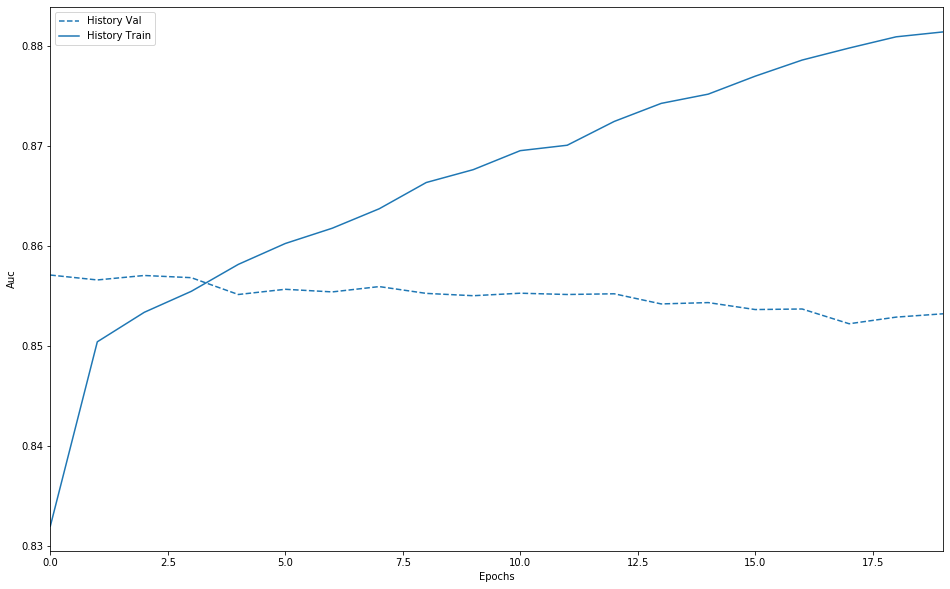

In [77]:
# plot history of ML model
def plot_history(histories, key='auc'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

plot_history([('History', histories[best_history_model])])

The model is not likely to become any better, as we can see the validation-AUC score lowers over time

In [62]:
model = tf.keras.models.load_model('kfold/{}.h5'.format(7))  # manual entry of number (of previous best model) after training

In [63]:
predicted = model.predict(X_test).flatten()

In [64]:
def print_accuracy(pred, real):
    print('Count: {}'.format(len(pred)))
    print('Nonzero pred: {}'.format(np.count_nonzero(pred)))
    print('Nonzero real: {}'.format(np.count_nonzero(real)))
    print('Nonzero real-pred: {}'.format(np.count_nonzero(real - pred)))

    wrong = np.count_nonzero(real - pred)  # any non-zero values are wrong, correct ones are always 0 (0-0, 1-1)
    print('acc: {}'.format((1-wrong/len(pred))*100))
    

In [65]:
print_accuracy([1 if x > 0.5 else 0 for x in predicted], y_test)
score(y_test, predicted)

Count: 18897
Nonzero pred: 864
Nonzero real: 1872
Nonzero real-pred: 1614
acc: 91.45896173995872
score: 0.8558320155126323


Here we can see our accuracy is pretty good, as well as the AUC score. Let's attempt the value count features.

### Testing a simple neural network on the added 200 features
Here we will disregard early stopping, simply to explore what a neural network can find in terms of patterns in the data. Here's the result with 100 epochs:

In [77]:
input_shape = [X_VC_train.shape[1]]

def build_model():
    model = tf.keras.Sequential([
        Dense(INPUT_DIM, activation=DEEP_ACTIVATION, input_shape=input_shape),
        Dropout(INPUT_DROPOUT),
        
        Dense(HIDDEN_DIM, activation=DEEP_ACTIVATION),
        Dropout(HIDDEN_DROPOUT),
        
        Dense(OUT_DIM, activation=DEEP_ACTIVATION),
        Dense(1, activation=OUT_ACTIVATION)
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['binary_crossentropy', AUC(curve='ROC', name='auc')],
    )
    return model

model = build_model()

# simple no-fold model for quick testing
vc_model = build_model()
history_vc = vc_model.fit(
    X_VC_train.values,
    y_vc_train.values,
    epochs=100,
    verbose=2,
    validation_split=0.2
)

Train on 136057 samples, validate on 34015 samples
Epoch 1/100
136057/136057 - 16s - loss: 0.3268 - binary_crossentropy: 0.3268 - auc: 0.5002 - val_loss: 0.3219 - val_binary_crossentropy: 0.3219 - val_auc: 0.5000
Epoch 2/100
136057/136057 - 15s - loss: 0.3256 - binary_crossentropy: 0.3256 - auc: 0.4966 - val_loss: 0.3217 - val_binary_crossentropy: 0.3217 - val_auc: 0.5000
Epoch 3/100
136057/136057 - 15s - loss: 0.3256 - binary_crossentropy: 0.3256 - auc: 0.5008 - val_loss: 0.3237 - val_binary_crossentropy: 0.3237 - val_auc: 0.5000
Epoch 4/100
136057/136057 - 15s - loss: 0.2961 - binary_crossentropy: 0.2961 - auc: 0.6875 - val_loss: 0.2561 - val_binary_crossentropy: 0.2561 - val_auc: 0.8383
Epoch 5/100
136057/136057 - 15s - loss: 0.2781 - binary_crossentropy: 0.2781 - auc: 0.7281 - val_loss: 0.2611 - val_binary_crossentropy: 0.2611 - val_auc: 0.7627
Epoch 6/100
136057/136057 - 15s - loss: 0.2735 - binary_crossentropy: 0.2735 - auc: 0.7473 - val_loss: 0.2475 - val_binary_crossentropy: 0.

In [86]:
vc_preds = vc_model.predict_proba(X_VC_test)
score(y_vc_test, vc_preds)

score: 0.8203234936054319


The score here is pretty much as expected. This was only an exploratory attempt at creating interesting features based on our observations earlier. Adding all the value counts resulted in noise in our model

# As noted earlier, we want to train on each feature individually. Here is an attempt with LightGBM

In [87]:
# load in test set:
test = get_data(custom_file='test.csv')
test = scale(test)
test.columns = X.columns

In [88]:
lgb_best_estimator.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 4000,
 'n_jobs': -1,
 'num_leaves': 5,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': False,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [89]:
# these params are set based on trial-and-error, initially based on the "lgb_best_estimator" from the grid search.
# however, due to the individual feature training, we ended up with different values.

# against the test subset and kaggle
DEPTH=2  # >3 resulted in overfitting
LEAVES=3  # lightgbm docs recommmend < 2^max_depth
LR=0.1  # no visible differences between 0.1->0.01
FEAT_FRAC=0.9  # fraction of features used, random sample
BAG_FRAC=0.8  # part of data selected
BAG_FREQ=2  # bagging at every N iteration
L1=4  # deal with regularization/overfitting
L2=16  # -:-


PARAMS = {
    'max_depth': DEPTH,
    'objective': 'binary',
    'num_leaves': LEAVES,
    'learning_rate': LR,
    'feature_fraction': FEAT_FRAC,
    'bagging_fraction': BAG_FRAC,
    'bagging_freq': BAG_FREQ,
    'lambda_l1': L1,
    'lambda_l2': L2,
}

paramstr = 'D{}L{}LR{}FEAT{}BAGF{}FREQ{}L1{}L2{}'.format(
    DEPTH,
    LEAVES,
    LR,
    FEAT_FRAC,
    BAG_FRAC,
    BAG_FREQ,
    L1, L2,
).replace('.', '_')  # avoid punctuation in file name
paramstr

'D2L3LR0_1FEAT0_9BAGF0_8FREQ2L14L216'

In [90]:
final_predictions = np.zeros([len(X.columns), len(test)])

for i in range(len(X.columns)):
    dataset = lgb.Dataset(X.iloc[:, i:i+1], y)
    # https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/simple_example.py
    # https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/sklearn_example.py
    
    # use LightGBM to fit a model on the specific feature, i
    model = lgb.train(PARAMS, dataset)

    # predict
    predictions = model.predict(test.iloc[:, i:i+1], model.best_iteration)
    
    #print('Predicted {} for feature {}'.format(predictions, feature))
    final_predictions[i, :] = predictions


In [91]:
_preds = (10*final_predictions).prod(axis=0)  # smooth values

In [92]:
IDs = ['test_{}'.format(i) for i in range(len(_preds))]
out_df = pd.DataFrame({
    'ID_code': IDs,
    'target': _preds.astype('float32')
})
out_df.to_csv(paramstr + '.csv', index=False)

# LightGBM Kaggle results while tuning parameters with the above solution

We renamed to reflect the parameter tuning of max depth

<img src="https://i.imgur.com/i4yxfHC.png" />

In [47]:
from catboost import CatBoostClassifier, Pool

X_train, X_test, y_train, y_test = split(X, y)
train_pool = Pool(data=X_train, label=y_train)
eval_set = Pool(data=X_test, label=y_test)

In [48]:
gridsearchmodel = CatBoostClassifier(loss_function='Logloss',
                                     eval_metric='AUC',
                                     task_type='GPU',
                                     verbose=False)
gridsearchmodel.fit(train_pool)

We ran an initial grid search with the following parameters (also seen in the image below). It ran for 3.5 hours.

    'learning_rate': [0.1, 0.06, 0.03, 0.01],
    'depth': [2, 4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'n_estimators': [100, 200, 400, 800],

<img src="https://i.imgur.com/6mgFrGm.png" />

to then get out:

{'depth': 4, 'l2_leaf_reg': 5, 'iterations': 800, 'learning_rate': 0.1}

as the best params. based on this. We tried one more. Keeping the depth, learning rate and l2, changing estimators:

'n_estimators': [800, 1200, 1600]

where 1600 was the best. We followed this process for a while, but ended up with overtraining using high number of iterations (>9000).

The final value we chose was 2000.

In [52]:
grid = {
    'learning_rate': [0.1],
    'depth': [4],
    'l2_leaf_reg': [3],
    'n_estimators': [2000, 3000],
}
res = gridsearchmodel.grid_search(grid, train_pool)

0:	loss: 0.8939520	best: 0.8939520 (0)	total: 1m 23s	remaining: 1m 23s
1:	loss: 0.8934941	best: 0.8939520 (0)	total: 3m 26s	remaining: 0us
Estimating final quality...


In [53]:
best_params = res['params']
best_params

{'depth': 4, 'l2_leaf_reg': 3, 'iterations': 2000, 'learning_rate': 0.1}

In [54]:
m = CatBoostClassifier(learning_rate=best_params['learning_rate'],
                       depth=best_params['depth'],
                       l2_leaf_reg=best_params['l2_leaf_reg'],
                       border_count=128,
                       eval_metric='AUC',
                       task_type='CPU', #Required for "aprox_on_full_history=True" according to documentation
                       iterations=best_params['iterations'],
                       boosting_type='Ordered', #Better on small datasets, but slower according to documentation
                       approx_on_full_history=True, #Slower and in rare cases more accurate according to documentation
                       verbose=False)

m.fit(train_pool)

Documentation on Catboost training parameters are found [here](https://catboost.ai/docs/concepts/python-reference_parameters-list.html)

In [63]:
preds_class = m.predict_proba(X_test)
preds_1 = [x[1] for x in preds_class]
score(y_test, preds_1)

score: 0.9291255451360091


In [84]:
real_test = pd.read_csv('test.csv')
real_test.pop('ID_code')

0              test_0
1              test_1
2              test_2
3              test_3
4              test_4
             ...     
199995    test_199995
199996    test_199996
199997    test_199997
199998    test_199998
199999    test_199999
Name: ID_code, Length: 200000, dtype: object

In [85]:
real_test = scale(real_test)
real_test

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.133982,2.327446,0.852790,1.286580,0.220422,0.339302,0.502075,0.507628,0.556964,1.007087,...,-1.174489,1.451559,-2.267588,-0.218044,-1.364614,1.818985,0.380899,1.962828,-0.131945,-0.526357
1,-0.700870,0.712423,0.226756,-0.780630,-1.162422,0.132014,0.699025,0.613951,-1.407056,-1.295199,...,1.631809,0.455057,-0.665993,1.703425,-0.770691,0.427340,-0.693329,1.041340,1.083560,-1.705010
2,-1.704490,-2.161579,-0.215177,0.126508,-0.503324,1.887818,-0.601566,1.087629,0.373846,0.628960,...,-0.865298,1.168601,0.036728,-0.285819,-1.597018,1.582008,-1.725840,-2.009582,1.338254,-1.916905
3,-0.698565,0.074754,0.499091,-0.103918,-1.379935,1.045199,-0.549870,1.178826,0.929500,-0.090601,...,1.401915,0.534953,-0.181048,0.064893,-0.894583,2.307698,0.305857,0.344306,-0.948042,-0.092749
4,0.344802,0.369148,1.299241,0.468835,-1.220512,-0.449119,1.670363,-1.730001,0.813551,-0.345580,...,0.227660,0.566588,-0.434095,0.013961,0.495832,-0.106558,-1.368278,-1.763736,-0.645853,-0.571065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.826244,0.652851,-0.104087,0.005596,-1.533605,0.112648,-0.644471,-0.515887,-0.900301,-0.467347,...,-0.249464,0.736032,1.856436,-1.173298,-1.631788,0.933749,-1.268817,0.265361,0.778080,0.781497
199996,-0.310085,-1.861640,-1.276880,1.146716,1.124191,1.025464,0.316458,0.688298,1.444295,-0.986236,...,0.399306,-0.265594,-0.071788,-0.228156,0.288709,-0.559598,0.130106,0.215845,0.766048,-1.685094
199997,0.321817,0.965510,0.189814,0.475801,0.991802,2.080619,-0.031068,0.540304,0.414945,-1.489864,...,0.431495,-1.589481,0.383629,-0.847363,0.657169,-0.727818,-1.183053,0.304996,-1.355626,-1.830047
199998,0.960172,0.274927,1.120380,0.339689,0.091373,-0.794628,-1.410069,0.087271,1.513084,1.082745,...,0.051884,0.344750,0.233354,0.610695,-0.315657,0.916262,-0.856907,-0.873631,-2.358381,0.291785


In [86]:
real_preds = m.predict_proba(real_test)
real_preds = [x[1] for x in real_preds]
IDs = ['test_{}'.format(i) for i in range(len(real_preds))]

In [87]:
subset_submission = pd.DataFrame({'ID_code': IDs, 'target': real_preds})
subset_submission.to_csv('cat271019-15-51.csv', index=False)

## Prediction results ✅

Testing different methods, we usually ended up with an accuracy of 0.9 (unsurprisingly) and an AUC-ROC score between 0.75 and 0.9. We are overall happy with our scores, as we clearly saw differences after doing grid searches for optimal parameters, etc. Neural networks gave surprisingly good results given the uncorrelated data! With an even bigger training set, this could be a possible solution for sure. However, the most elegant solution ended up being CatBoost, also one of the fastest running models.

### Kaggle results, CatBoost
Submitting the above solution, we're very happy that it resulted in similar results to our own test-split. Maybe it's not the most solid result, but it's consistent with what we've tested.
<img src="https://i.imgur.com/Wu0OPAg.png" />


In [69]:
m.save_model('catboost_big_train.h5')

## Interpretation and conclusion 👩‍🏫

Let's base our interpretations around the final solution with CatBoost. Some more interpretation can be found above in the outputs from the models.

As we have confirmation from training on the large training set, and getting a good score on kaggle on the full test-set, we have confidence and proof of that our models perform fairly well.

The hyperparameter grid search has provided us with the best possible hyperparameters according to our validation split and we can therefore have confidence in training on the full train_subset for our final delivery as we have already optimized the hyperparameters to some extent. 

### Interpreting the results

The final catboost model turned out to be fairly simple, after tuning the parameters properly.

We install eli5, a model explanation kit, to look at some properties of the model:

In [8]:
!pip install eli5
from eli5 import catboost

In [12]:
import os
os.environ['PATH'] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
#m.plot_tree(tree_idx=0, pool=train_pool)

## The above snippet doesn't show on saved notebooks after shutting down the kernel, as it loads from a locally installed program, Graphviz.

It simply shows a decision tree, starting at the top feature, visaluzing how the nodes lose or gain value from several splits. The values were unsurprisingly very low, as the correlations are nearing zero.

In [10]:
catboost.explain_weights_catboost(m, top=200)

Weight,Feature
0.0219,81
0.0196,139
0.0153,6
0.0152,12
0.0150,110
0.0148,53
0.0140,26
0.0137,76
0.0132,174
0.0128,146


While there is a definite difference between the top 10 features, there are a huge number of features with relatively low weight. Note that the weight is low even for the top result, `0.0219`. 

We cannot confirm or disprove much of what we have earlier discussed. Although we can see that feature `68`, that we argued looked suspicious, has an extremely low weight of `0.0015`.

## Conclusion 
The kaggle challenge proved to be a fun and educational challenge where we have had the opportunity to learn many key techniques in practical work with exploratory data analysis, data preprocessing and machine learning models. We are especially grateful for that by giving us students an actual kaggle challenge, we both get to work with the entire pipeline from raw data to a prediction result, as well as that we know that the problem at hand is both relevant and a challenging problem to solve. 